# Idea: mixtures are hypercubes in copula space. So use decision tree as classifier copula.

In [63]:
import sklearn as sk
from sklearn import tree
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from tqdm import tqdm

(0.0, 1.0)

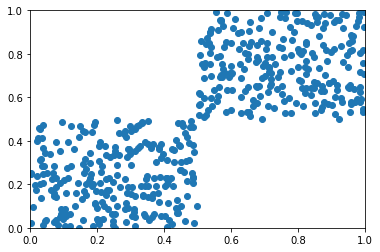

In [18]:
# Get copula data
data_p = np.concatenate([np.random.random((250,2))/2,0.5+np.random.random((250,2))/2])
plt.scatter(data[:,0],data[:,1])
plt.ylim(0,1)
plt.xlim(0,1)

In [89]:
# Fit classifier
N_q = 5000
data_q = np.random.random((N_q,2))
data_p_upsampled = sk.utils.resample(data_p, replace=True, n_samples=N_q, random_state=42)
X = np.concatenate([data_p_upsampled,data_q])
Y = np.concatenate([np.ones(N_q),np.zeros(N_q)])
chp = tree.DecisionTreeClassifier(criterion='entropy')
chp = chp.fit(X, Y)

In [76]:
chp.predict_proba(np.array([[0.8,0.2]]))

array([[0.50600568, 0.49399432]])

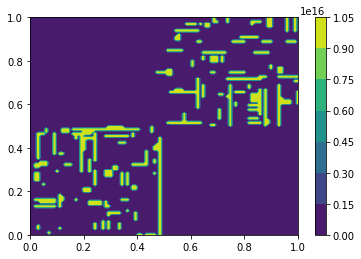

In [90]:
# compute r(x)/(1-r(x)) = cop(x)
def cop(x):
    return chp.predict_proba(np.array([x]))[0,1]/np.clip(1-chp.predict_proba(np.array([x]))[0,1],1e-16,1-(1e-16))

# plot it on meshgrid
x_ = np.linspace(0,1,100)
y_ = np.linspace(0,1,100)
X_, Y_ = np.meshgrid(x_,y_)
Z = np.zeros_like(X_)
for i in range(100):
    for j in range(100):
        Z[i,j] = cop(np.array([X_[i,j],Y_[i,j]]))

plt.contourf(X_,Y_,Z)
plt.colorbar()
plt.show()

### AdaBoosting

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


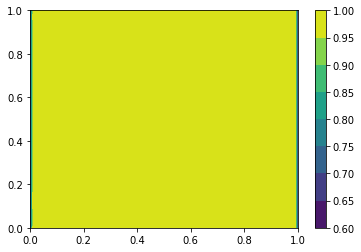

In [92]:
# fit classifier with AdaBoost
cht = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=990109)
cht.fit(X, Y)

# compute r(x)/(1-r(x)) = cop(x)
def cop(x):
    cop = cht.predict_proba(np.array([x]))[0,1]/np.clip(1-cht.predict_proba(np.array([x]))[0,1],1e-6,1-(1e-6))
    return cop.clip(0,1)

# plot it on meshgrid
x_ = np.linspace(0,1,100)
y_ = np.linspace(0,1,100)
X_, Y_ = np.meshgrid(x_,y_)
Z = np.zeros_like(X_)
for i in tqdm(range(100)):
    for j in range(100):
        Z[i,j] = cop(np.array([X_[i,j],Y_[i,j]]))

plt.contourf(X_,Y_,Z)
plt.colorbar()
plt.show() 